In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
#Loading the training data
myData = input_data.read_data_sets('MNIST_data')        

In [0]:
tf.reset_default_graph()

MNIST images have a dimension of 28 * 28 pixels with one color channel. Input X_INPUT will be batches of MNIST characters. The network will learn to reconstruct them and output them in a placeholder Y_OUTPUT, which has the same dimensions. Y_FLATTENED will be used later, when computing losses. KEEP_PROB will be used when applying dropouts as a means of regularization.

In [0]:
BATCH_SIZE = 64
#Defining input and output data
X_INPUT = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y_OUTPUT = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_FLATTENED = tf.reshape(Y_OUTPUT, shape=[-1, 28*28])
KEEP_PROB = tf.placeholder(dtype=tf.float32, shape=(), name='KEEP_PROB')


DEC_IN_CHANNELS = 1
NUM_LATENS = 8
RESHAPED_DIM = [-1, 7, 7, DEC_IN_CHANNELS]
INPUTS_DECODER = 24

In [0]:
def encoder(x_input, keep_prob):
    """
        Applies 3 layers of convolutions to the input data with dropout
    """
    with tf.variable_scope("encoder"):

        # Flatten the input
        x = tf.reshape(x_input, shape=[-1, 28, 28, 1])

        # CONV L1
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME', activation=tf.nn.leaky_relu)
        # L1 DROPOUT
        x = tf.nn.dropout(x, keep_prob)

        # CONV L2
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME', activation=tf.nn.leaky_relu)
        # L2 DROPOUT
        x = tf.nn.dropout(x, keep_prob)

        # CONV L3
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='SAME', activation=tf.nn.leaky_relu)
        # L3 DROPOUT
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        x_dense = tf.layers.dense(x, units=NUM_LATENS)
        sd = 0.5 * tf.layers.dense(x, units=NUM_LATENS)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], NUM_LATENS]))
        z = x_dense + tf.multiply(epsilon, tf.exp(sd))

        return z, x_dense, sd

In [0]:
def decoder(sampled_z, keep_prob):
    """
        Regenerate an image using coded images
    """
    with tf.variable_scope("decoder"):
        x = tf.layers.dense(sampled_z, units=INPUTS_DECODER, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=INPUTS_DECODER*2 + 1, activation=tf.nn.leaky_relu)

        x = tf.reshape(x, RESHAPED_DIM)

        # TRANSPOSED CONV 1-3 + DROPOUTS
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)

        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])

        return img

In [0]:
CODED_IMG, MN, SD = encoder(X_INPUT, KEEP_PROB)
DECODED_IMG = decoder(CODED_IMG, KEEP_PROB)

In [0]:
UN_RESHAPED = tf.reshape(DECODED_IMG, [-1, 28*28])
delta1 = tf.constant(4.5)
a1 = tf.reduce_sum(tf.squared_difference(UN_RESHAPED, Y_FLATTENED), 1)
# Image reconstruction loss
IMG_LOSS = tf.multiply(tf.square(delta1), tf.sqrt(1. + a1/tf.square(delta1)) - 1.)
# KL divergence loss
LATENT_LOSS = -0.5 * tf.reduce_sum(1.0 + 2.0*SD - tf.square(MN) - tf.exp(2.0*SD), 1)
LOSS = tf.reduce_mean(IMG_LOSS + LATENT_LOSS)
OPTIMIZER = tf.train.AdamOptimizer(0.0005).minimize(LOSS)

In [0]:
SESS = tf.Session()
SESS.run(tf.global_variables_initializer())


In [0]:
#Training the network
for i in range(1500):
    BATCH = [np.reshape(b, [28, 28]) for b in myData.train.next_batch(batch_size=BATCH_SIZE)[0]]
    SESS.run(OPTIMIZER, feed_dict={X_INPUT: BATCH, Y_OUTPUT: BATCH, KEEP_PROB: 0.8})

    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigma = SESS.run([LOSS, DECODED_IMG, IMG_LOSS, LATENT_LOSS, MN, SD],
        feed_dict={X_INPUT: BATCH, Y_OUTPUT: BATCH, KEEP_PROB: 1.0})
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

0 43.159126 43.157017 0.002107344
200 18.428791 18.347586 0.08120561
400 17.510725 17.160767 0.3499576
600 17.765636 17.438187 0.32744837
800 17.685162 16.952358 0.7328056
1000 16.965015 15.858191 1.1068242
1200 17.015224 15.630013 1.3852115
1400 17.09377 15.1971035 1.8966639


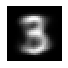

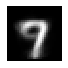

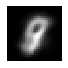

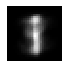

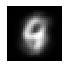

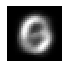

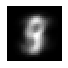

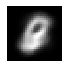

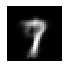

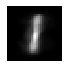

In [0]:
#Generating new data
RANDOM_CODE = [np.random.normal(0, 1, NUM_LATENS) for _ in range(10)]
IMAGES = SESS.run(DECODED_IMG, feed_dict={CODED_IMG: RANDOM_CODE, KEEP_PROB: 1.0})
IMAGES = [np.reshape(IMAGES[i], [28,28]) for i in range(len(IMAGES))]

for img in IMAGES:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()